# Sentiment Analysis with VADER and NLP Modeling

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

## Load in the text data:

- Remove retweets
- Keep only the `handle` and `text` columns
- Reset the index

In [3]:
from google.colab import drive
drive.mount("/content1")

Mounted at /content1


In [4]:
tweets = pd.read_csv('/data/trump_clinton_tweets.csv')

# remove retweets
tweets = tweets[tweets['is_retweet'] == False]

# keep only handle and text
tweets = tweets[['handle', 'text']]

# reset index
tweets.reset_index(drop=True, inplace=True)

## Instantiate `SentimentIntensityAnalyzer` and test it on the first tweet:

- We'll use the `.polarity_scores()` method
- `.polarity_scores()` works on one string at a time

In [15]:
sia = SentimentIntensityAnalyzer()

print(tweets['text'][0])
sia.polarity_scores(tweets['text'][0])

The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG


{'compound': 0.4404, 'neg': 0.0, 'neu': 0.861, 'pos': 0.139}

## Create a dataframe called `scores` that stores the sentiment scores for each tweet in `tweets`:

In [16]:
dicts = []

for tweet in tweets['text']:
    scores = sia.polarity_scores(tweet)
    dicts.append(scores)

scores = pd.DataFrame(dicts)
scores.head()

,neg,neu,pos,compound
0,0.000,0.861,0.139,0.4404
1,0.101,0.771,0.128,0.1376
2,0.278,0.722,0.000,-0.6597
3,0.000,0.858,0.142,0.3595
4,0.000,0.796,0.204,0.4767


## Concatenate `tweets` and `scores` and store:

In [17]:
df = pd.concat([tweets, scores], axis=1)

## Investigating polarities:

- You can explore the most strongly scored tweets with `.sort_values()`.
- Compare `compound` to `neg` and `pos`.

In [18]:
df.sort_values(by='neg', ascending=False).head(20)

,handle,text,neg,neu,pos,compound
3355,HillaryClinton,Disgusting. https://t.co/A8Hm24ZT1H,0.773,0.227,0.000,-0.5267
1528,realDonaldTrump,"Even Bill is tired of the lies, SAD! https://t.co/LPk1OkwH9P",0.621,0.379,0.000,-0.8697
3988,HillaryClinton,Hate isn't an American value. https://t.co/lZJ8T0Xu3M,0.589,0.411,0.000,-0.6943
2923,HillaryClinton,Your @GOP presidential nominee responding to a terrorist attack with lies and conspiracy theories.\nhttps://t.co/TZJmXefmx4,0.583,0.417,0.000,-0.9325
2877,HillaryClinton,"Gun violence and hate aren't isolated—homophobia in Orlando, racism in Charleston. We need to fight them together. https://t.co/HcBJzknBz7",0.565,0.435,0.000,-0.9509
4541,realDonaldTrump,"""@Ma1973sk: Actually, no @FoxNews, @megynkelly has a sick obsession with Trump. Every day, every show, trashing, negative, hate.",0.560,0.440,0.000,-0.9360
2583,realDonaldTrump,"Yet another terrorist attack today in Israel -- a father, shot at by a Palestinian terrorist, was killed while:\nhttps://t.co/Cv1HzKVbiT",0.548,0.452,0.000,-0.9584
1321,HillaryClinton,"Donald Trump's no good, horrible, very bad week. https://t.co/MtgwywgJ3q",0.546,0.287,0.167,-0.7645
2659,HillaryClinton,"""Hillary believes that racism, hatred, injustice, and bigotry have no place in our country."" —@ElizabethforMA\nhttps://t.co/OK5UueAaZn",0.542,0.458,0.000,-0.9349
3009,realDonaldTrump,Really bad shooting in Orlando. Police investigating possible terrorism. Many people dead and wounded.,0.536,0.464,0.000,-0.9286


## Visualizing sentiments

### Plot the average positivity and negativity for each politician:

- You can do this with a `.groupby()` and `.plot()` in one line.

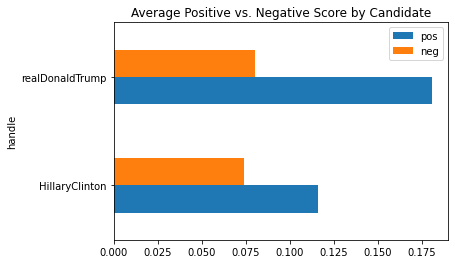

In [19]:
df.groupby('handle').mean()[['pos', 'neg']].plot(kind='barh')
plt.title('Average Positive vs. Negative Score by Candidate');

### Plot a boxplot of compound scores for each politician:

- You can do this with seaborn's `.catplot()` if you so choose.

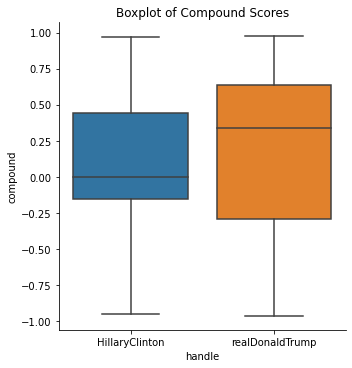

In [20]:
sns.catplot(x='handle', y='compound', kind='box', data=df)
plt.title('Boxplot of Compound Scores');

### Plot a boxplot of positive scores for each politician:

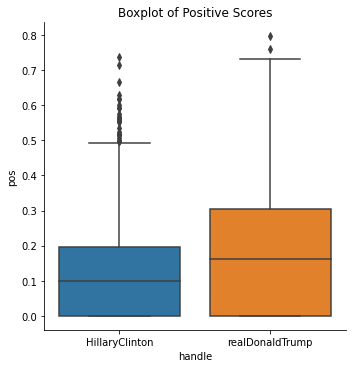

In [21]:
sns.catplot(x='handle', y='pos', kind='box', data=df)
plt.title('Boxplot of Positive Scores');

### Plot a boxplot of neutral scores for each politician:

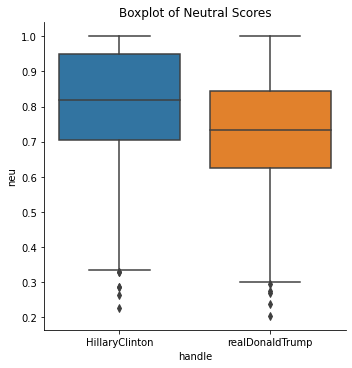

In [22]:
sns.catplot(x='handle', y='neu', kind='box', data=df)
plt.title('Boxplot of Neutral Scores');

# Modeling

In [23]:
df.head(3)

,handle,text,neg,neu,pos,compound
0,HillaryClinton,The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG,0.000,0.861,0.139,0.4404
1,HillaryClinton,"If we stand together, there's nothing we can't do. \n\nMake sure you're ready to vote: https://t.co/tTgeqxNqYm https://t.co/Q3Ymbb7UNy",0.101,0.771,0.128,0.1376
2,HillaryClinton,Both candidates were asked about how they'd confront racial injustice. Only one had a real answer. https://t.co/sjnEokckis,0.278,0.722,0.000,-0.6597


### Set up X and y, then train-test split

In [24]:
df['is_trump'] = df['handle'].map(lambda x: 1 if x == 'realDonaldTrump' else 0)

In [25]:
X = df['text']
y = df['is_trump']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

### Check baseline accuracy rate

In [26]:
y_train.mean(), y_test.mean()

(0.5404334653926823, 0.5408805031446541)

### Instantiate and fit a count vectorizer

In [27]:
cv = CountVectorizer(min_df=3, max_features=2000)

cv.fit(X_train, y_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=2000, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### Transform X_test and X_train

In [28]:
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

### Instantiate and fit a logistic regression
- You may want to use `%%capture` or otherwise suppress warnings

In [29]:
%%capture
# h/t 
lr = LogisticRegressionCV()
lr.fit(X_train_cv, y_train)

### Score on train and test

In [30]:
lr.score(X_train_cv, y_train), lr.score(X_test_cv, y_test)

(0.9909112095082732, 0.9196366177498253)

### Investigate coefficients

In [31]:
coef_df = pd.DataFrame({
    'coefs': cv.get_feature_names(),
    'vals': lr.coef_[0]})

### What words are predictive of authorship?

In [32]:
coef_df.sort_values('vals').head(20)

,coefs,vals
1346,potus,-2.835593
1771,timkaine,-2.729889
195,berniesanders,-2.604799
925,joebiden,-2.443623
449,demsinphilly,-2.401845
1923,week,-2.263300
206,billclinton,-2.181595
1434,reality,-2.013156
412,dangerous,-1.944738
169,barack,-1.913908


In [33]:
coef_df.sort_values('vals', ascending=False).head(20)

,coefs,vals
1807,trump2016,4.035363
403,crooked,4.004931
1064,makeamericagreatagain,3.885513
407,cruz,3.225321
1808,trumppence16,3.043565
1056,maga,2.793667
404,crookedhillary,2.706845
1065,makeamericasafeagain,2.658937
732,gopdebate,2.528460
864,imwithyou,2.524807


# Bonus: Using Pipelines to make predictions on novel text

Because a pipeline can wrap up count-vectorizing as well as the modeling step, we can use pipelines to make predictions about what a piece of text [sounds like](https://iwl.me/).

- You may want to use `%%capture` or otherwise suppress warnings.

In [34]:
%%capture
pipe = Pipeline([
    ('cv', CountVectorizer(min_df=3, max_features=2000)),
    ('lr', LogisticRegressionCV())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

In [35]:
pipe.predict(['maga'])

array([1])

In [36]:
pipe.predict(['timkaine'])

array([0])

In [37]:
pipe.predict(['Bonus: Using Pipelines to make predictions on novel text'])

array([1])